In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import cmath

from tqdm import tqdm

### 位相振動子
$\dfrac{d\phi_{i}}{dt}=\omega_{i}+\displaystyle \sum_{j\neq i}^N J_{ij}\sin (\phi_{j}-\phi_{i}+\beta_{ij})$\
$J_{ij}=|C_{ij}|, \beta_{ij}=argC_{ij}, C_{ij}= \displaystyle \sum_{\mu=1}^{P} e^{i(\theta_{i}^{\mu}-\theta_{j}^{\mu})}$\
$\phi_{i}$:細胞iの位相(振動子としての)。$\phi_{i}= \theta_{i}^{\mu}+const$である。\
$\omega_{i}$:細胞iの振動周期(全て同じor狭い幅での分布で与える)\
$C_{ij}$:全てのパターン$\mu \in P$において、細胞iとjの位相差に相当する複素指数関数$e^{i(\theta_{i}^{\mu}-\theta_{j}^{\mu})}$を足し合わせたもの。\
$J_{ij}$:細胞iとjの相互作用パラメター。$C_{ij}$の複素座標上での絶対値。\
$\beta_{ij}$:細胞iとjの位相結合バイアス的なもの？$C_{ij}$の偏角。

In [451]:
'''
Calculate the simirality degree between specific pattern and retrieved pattern.

pat_no  :Pattern number to calculate the simirality
phi     :Retrieved neural firing pattern(snapshot on the particular time).
theta   :Memorized pattern in the network.
'''
def R_mu(theta, phi, pat_no):
    N = len(phi)
    theta_mu = theta[pat_no]
    rect_mu = 0 + 0j
    for i in range(N):
        rect_mu += cmath.rect(1,phi[i]-theta_mu[i])
#         print("phi:",phi[i], 'theta:',theta_mu[i])
    R_mu = (1/N)*abs(rect_mu)
    return R_mu

In [477]:
'''
node  :Node number in the network.
pat   :Pattern number to memorize on the network.
theta :List of phase between two nodes to memorize on the network.
omega :List of angular velocity for each node.
'''

node = 100
pat = 3
theta = (np.random.rand(pat,node)-0.5)*2*np.pi ##pattern_number * node_number 
omega = np.ones(node)*(2*np.pi/100) ## 100ms/cycle

C = np.zeros((node,node),dtype=np.complex128) # mutual interaction 
for i in range(node):
    for j in range(node):
        for mu in range(pat):
            C[i][j] += cmath.rect(1,theta[mu,i]-theta[mu,j])
C /= pat
J = abs(C)
B = np.zeros((node,node))
for i in range(node):
    for j in range(node):
        B[i][j] = cmath.phase(C[i][j])

        

In [504]:
'''
Simulation block
dt          :Time step of the simulation(ms).
T           :Length of simulation time(ms).
pat_no      :Pattern number of initial state
noise_level :Noise multipled to initial state
phi         :Phase of the attractor in each node. phi[0] = initial state of the attractor
K           : Strength parameter of node connection
'''

## Set variable
dt = 1
T = 200
pat_no = 0
noise_level = 0
phi = np.copy(theta[pat_no])*0.45 + np.copy(theta[2])*0.55
K = 1

## Switch the value of phi randomly
dice = list(range(node))
for i in range(noise_level):
    index = np.random.choice(dice,2)
    phi[index[0]], phi[index[1]] = phi[index[1]], phi[index[0]]
    
## Calculate the similarity degree of the initial state
R_init = []
for mu in range(pat):
    R_init.append(R_mu(theta, phi,mu))

## Simulattion
Phi_log = np.empty((node,0))
dph = np.zeros(node)
for t in tqdm(range(int(T/dt))):
    Phi_log = np.hstack((Phi_log, np.reshape(phi,(node,-1))))
    for i in range(node):
        mutual = 0
        for j in range(node):
            if i!=j:
                mutual += J[i][j]*np.sin(phi[j]-phi[i]+B[i][j])
        dph[i] = (omega[i]+(K/node)*mutual)*dt
    phi += dph
    phi = phi%(2*np.pi)

100%|██████████| 200/200 [00:04<00:00, 41.38it/s]


R^mu initial [0.20791177215242562, 0.11104948753803041, 0.389393625676454]
R^mu finally [0.13722065994020646, 0.21627830813566584, 0.9841807250541001]


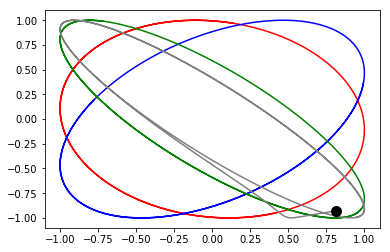

In [505]:
attractor1=np.empty((0,2))
attractor2=np.empty((0,2))
attractor3=np.empty((0,2))
axis1=0
axis2=9

for i in range(1000):
    attractor1 = np.vstack((attractor1, np.array([theta[0][axis1]+i*0.01,theta[0][axis2]+i*0.01])))
    attractor2 = np.vstack((attractor2, np.array([theta[1][axis1]+i*0.01,theta[1][axis2]+i*0.01])))
    attractor3 = np.vstack((attractor3, np.array([theta[2][axis1]+i*0.01,theta[2][axis2]+i*0.01])))
    
plt.figure()
plt.plot(np.sin(Phi_log[axis1]), np.sin(Phi_log[axis2]), color='gray', label='simulation', zorder=2)
plt.plot(np.sin(attractor1[:,0]), np.sin(attractor1[:,1]), color='r', label='attractor1', zorder=1)
plt.plot(np.sin(attractor2[:,0]), np.sin(attractor2[:,1]), color='b', label='attractor2', zorder=1)
plt.plot(np.sin(attractor3[:,0]), np.sin(attractor3[:,1]), color='g', label='attractor2', zorder=1)
plt.scatter(np.sin(Phi_log[axis1][0]), np.sin(Phi_log[axis2][0]), color='k', label="startpoint", s=100, zorder=3)

R = []
for mu in range(pat):
    R.append(R_mu(theta, Phi_log[:,T-1], mu))
print('R^mu initial', R_init)
print('R^mu finally', R)